# Channel Importance Analysis
In this notebook, I will analyze the importance of a certain channel in differentiating between same word pairs vs. different word pairs from within blocks.

##### Metric:
The importance of a channel is measured by the statistical differences in its cosine similarities

For example, does channel 1 differentiate between BRICK_CLOCK vs. BRICK_CLOCK & BRICK_CLOCK vs. GLASS_JUICE?

Reference: within blocks - data mining

In [7]:
# Import Necessary Libraries
import numpy as np
import scipy.io

import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.decomposition import PCA
import scipy.stats as stats
from scipy.spatial import distance as Distance

# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

%matplotlib inline

In [38]:
#### Extract wordpairs data into a dictionary for a subject/session/block
#### dictionary{wordpair:{channels}}
def extractSubjSessionBlockData(subj, session, block):
    # file directory for a subj/session/block
    filedir = '../../condensed_data_' + subj + '/sessions/' + session + '/' + block
    wordpairs = os.listdir(filedir) 
    
    # initialize data dictionary with meta data
    data_dict = {}
    data_dict['meta'] = {'subject': subj,
                         'session': session,
                         'block': block}
    data_dict['data'] = {}
    for wordpair in wordpairs:    # loop thru all wordpairs
        wordpair_dir = filedir + '/' + wordpair
        all_channel_mats = os.listdir(wordpair_dir)
        
        data_dict['data'][wordpair] = {}
        for channel in all_channel_mats: # loop thru all channels
            chan_file = wordpair_dir + '/' + channel

            ## 00: load in data
            data = scipy.io.loadmat(chan_file)
            data = data['data']
            
            ## 01: get the time point for probeword on
            timeZero = data['timeZero'][0][0][0]
        
            ## 02: get the time point of vocalization
            vocalization = data['vocalization'][0][0][0]
        
            ## 03: Get Power Matrix
            power_matrix = data['powerMatZ'][0][0]
            
            chan = channel.split('_')[0]
            
            # convert channel data into a json dict
            data_dict['data'][wordpair][chan] = {'timeZero': timeZero,
                                          'timeVocalization':vocalization,
                                          'powerMat': power_matrix}
            
    return data_dict

def isReverse(pair1, pair2):
    pair1split = pair1.split('_')
    pair2split = pair2.split('_')
    if pair1split[0] == pair2split[1] and pair1split[1] == pair2split[0]:
        return True
    else:
        return False

# Compute all pairwise distances between first_mat to second_mat
def computePairDistances(first_mat, second_mat):
    distance_list = []
    for idx in range(0, first_mat.shape[0]):
        distance_list.append([distances(x, first_mat[idx,:]) for x in second_mat])
    distance_list = 1.0 - np.ndarray.flatten(np.array(distance_list))
    return distance_list  
    
distances = Distance.cosine # define distance metric to use
def computeWithinDistances(mat):
    distance_list = np.array(())
    
    distance_list = []
    for idx in range(0, mat.shape[0]):
        for x in mat[idx+1:,:]:
            dist = distances(x,mat[idx,:])
            to_append = np.array(dist)
            distance_list.append(to_append)
            
    distance_list = 1.0 - np.ndarray.flatten(np.array(distance_list))
    return distance_list

def createWordGroups(wordpairs):
    # create same group pairs
    for idx, pair in enumerate(wordpairs):
        same_word_group.append([pair, pair])

    # create reverse, and different groups
    for idx, pairs in enumerate(itertools.combinations(wordpairs,2)):
        if isReverse(pairs[0], pairs[1]):
            reverse_word_group.append([pairs[0], pairs[1]])
        else:
            diff_word_group.append([pairs[0], pairs[1]])
            
    return same_word_group, reverse_word_group, diff_word_group

In [82]:
def channelSignificance(chan, same_word_group, reverse_word_group, diff_word_group, block_data, freq_bands):
    ################# 02a: Same Words Cosine Distnace #################
    # extract channel data for same word group
    same_word_dict = {}
    same_word_distances = np.array(())
    for same_words in same_word_group:
        same_word_data = [] # array to store all the feature freq. vectors for a specific word

        # extract data to process - average across time 
        same_word_key = same_words[0]
        probeOnTime = block_data['data'][same_word_key][str(chan)]['timeZero']
        vocalizationTime = block_data['data'][same_word_key][str(chan)]['timeVocalization']
        powerMat = block_data['data'][same_word_key][str(chan)]['powerMat']

        for i in range(0, len(vocalizationTime)):
            # either go from timezero -> vocalization, or some other timewindow
            same_word_data.append(np.ndarray.flatten(np.mean(powerMat[i,freq_bands,probeOnTime:vocalizationTime[i]-1],axis=1)))
        same_word_data = np.array(same_word_data)
        # do a pairwise comparison of all events in this word pair
        same_word_data = computeWithinDistances(same_word_data)
        same_word_dict[same_word_key] = same_word_data
    # convert into list of distances
    for key in same_word_dict.keys():
        if same_word_distances.size == 0:
            same_word_distances = same_word_dict[key]
        else:
            same_word_distances = np.append(same_word_distances, same_word_dict[key], axis=0)

    ################# 02b: Reverse Words Cosine Distnace #################
    # extract channel data for same word group
    reverse_word_dict = {}
    reverse_word_distances = np.array(())
    for reverse_words in reverse_word_group:
        reverse_word_data = {}

        for wdx, word in enumerate(reverse_words): # get the first and second word pair
            reverse_word_databuffer = []

            # extract wordKey and data from MAIN block dictinoary
            reverse_word_key = reverse_words[wdx]
            probeOnTime = block_data['data'][reverse_word_key][str(chan)]['timeZero']
            vocalizationTime = block_data['data'][reverse_word_key][str(chan)]['timeVocalization']
            powerMat = block_data['data'][reverse_word_key][str(chan)]['powerMat']

            # average across time and append a frequency feature vector for every event in this group
            for i in range(0, len(vocalizationTime)):
                # either go from timezero -> vocalization, or some other timewindow
                reverse_word_databuffer.append(np.ndarray.flatten(np.mean(powerMat[i,freq_bands,probeOnTime:vocalizationTime[i]-1],axis=1)))
            reverse_word_data[str(wdx)] = np.array(reverse_word_databuffer)

        # do a pairwise comparison of all events in this word pair
        reverse_word_dict['vs'.join(reverse_words)] = computePairDistances(reverse_word_data['0'], reverse_word_data['1'])
    # convert into list of distances
    for key in reverse_word_dict.keys():
        if reverse_word_distances.size == 0:
            reverse_word_distances = reverse_word_dict[key]
        else:
            reverse_word_distances = np.append(reverse_word_distances, reverse_word_dict[key])

    ################# 02c: Different Words Cosine Distnace #################
    # extract channel data for same word group
    diff_word_dict = {}
    diff_word_distances = np.array(())
    for diff_words in diff_word_group:
        diff_word_data = {}

        # extract data to process - average across time 
        for wdx, word in enumerate(diff_words): # get the first and second word pair
            diff_word_databuffer = []

            # extract wordKey and data from MAIN block dictinoary
            diff_word_key = diff_words[wdx]
            probeOnTime = block_data['data'][diff_word_key][str(chan)]['timeZero']
            vocalizationTime = block_data['data'][diff_word_key][str(chan)]['timeVocalization']
            powerMat = block_data['data'][diff_word_key][str(chan)]['powerMat']

            # average across time and append a frequency feature vector for every event in this group
            for i in range(0, len(vocalizationTime)):
                # either go from timezero -> vocalization, or some other timewindow
                diff_word_databuffer.append(np.ndarray.flatten(np.mean(powerMat[i,freq_bands,probeOnTime:vocalizationTime[i]-1],axis=1)))
            diff_word_data[str(wdx)] = np.array(diff_word_databuffer)

        # do a pairwise comparison of all events in this word pair
        diff_word_dict['vs'.join(diff_words)] = computePairDistances(diff_word_data['0'], diff_word_data['1'])
    # put all word distances into 1 list
    for key in diff_word_dict.keys():
        if diff_word_distances.size == 0:
            diff_word_distances = diff_word_dict[key]
        else:
            diff_word_distances = np.append(diff_word_distances, diff_word_dict[key])
    
    ##### RUN STATS COMPARISONS ON SAME VS. REVERSE, SAME VS. DIFF, 
    random_subset = np.random.choice(range(same_word_distances.shape[0]), size=len(same_word_distances)/2, replace=False)
    random_subset2 = list(set(np.arange(0, len(same_word_distances))) - set(random_subset))
    same_X = same_word_distances[random_subset]
    same_Y = same_word_distances[random_subset2]

    ## perform ks 2-sample test
    stat, same_p_val = stats.ks_2samp(same_X, same_Y)
    stat, reverse_p_val = stats.ks_2samp(same_word_distances, reverse_word_distances)
    stat, diff_p_val = stats.ks_2samp(same_word_distances, diff_word_distances)
    ## perform t-test same vs same, same vs reverse, same vs different
#     stat, same_p_val = stats.ttest_ind(same_X, same_Y)
#     stat, reverse_p_val = stats.ttest_ind(same_word_distances, reverse_word_distances)
#     stat, diff_p_val = stats.ttest_ind(same_word_distances, diff_word_distances)
    
    # return the statistical comparison for this channel
    return same_p_val, reverse_p_val, diff_p_val

In [85]:
import collections
################################### HYPER-PARAMETERS TO TUNE #######################################################
distances = Distance.cosine # define distance metric to use
num_time_windows = 10
low_freq_bands = [0, 1]
med_freq_bands = [2, 3, 4]
high_freq_bands = [5, 6]
freq_bands = np.arange(0,7,1)

np.random.seed(123456789)  # for reproducibility, set random seed

num_chans = 72
freq_labels = ['delta', 'theta', 'alpha', 'beta', 'low gamma', 'high gamma', 'HFO']


print 'low bands: ', [freq_labels[i] for i in low_freq_bands]
print 'mid bands: ', [freq_labels[i] for i in med_freq_bands]
print 'high bands: ', [freq_labels[i] for i in high_freq_bands]
print "The length of the feature vector for each channel will be: ", num_time_windows*len(freq_bands), \
            ' total=', num_chans*num_time_windows*len(freq_bands)

low bands:  ['delta', 'theta']
mid bands:  ['alpha', 'beta', 'low gamma']
high bands:  ['high gamma', 'HFO']
The length of the feature vector for each channel will be:  70  total= 5040


Analyzing session  session_0
Analyzing block  BLOCK_0
(1, 72)
Analyzing block  BLOCK_1
(2, 72)
Analyzing block  BLOCK_2
(3, 72)
Analyzing block  BLOCK_3
(4, 72)
Analyzing block  BLOCK_4
(5, 72)
Analyzing block  BLOCK_5
(6, 72)
(6, 72)
different {0.0: 10, 1.0: 422}
same {0.0: 22, 1.0: 410}
reverse {0.0: 4, 1.0: 428}
Analyzing session  session_1
Analyzing block  BLOCK_0
(1, 72)
Analyzing block  BLOCK_1
(2, 72)
Analyzing block  BLOCK_2
(3, 72)
Analyzing block  BLOCK_3
(4, 72)
Analyzing block  BLOCK_4
(5, 72)
Analyzing block  BLOCK_5
(6, 72)
(6, 72)
different {0.0: 14, 1.0: 418}
same {0.0: 19, 1.0: 413}
reverse {0.0: 23, 1.0: 409}
Analyzing session  session_3
Analyzing block  BLOCK_0
(1, 72)
Analyzing block  BLOCK_1
(2, 72)
Analyzing block  BLOCK_2
(3, 72)
Analyzing block  BLOCK_3
(4, 72)
Analyzing block  BLOCK_4
(5, 72)
Analyzing block  BLOCK_5
(6, 72)
(6, 72)
different {0.0: 17, 1.0: 415}
same {0.0: 27, 1.0: 405}
reverse {0.0: 17, 1.0: 415}


/Users/adam2392/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/adam2392/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/adam2392/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:80: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


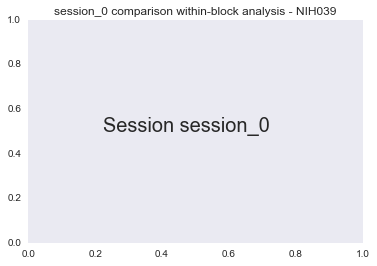

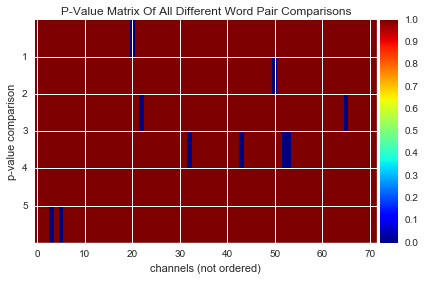

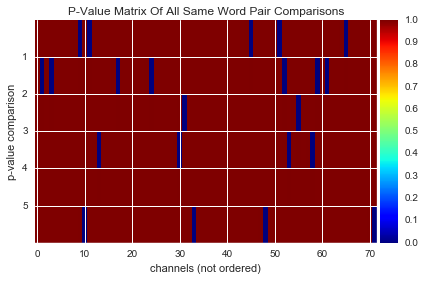

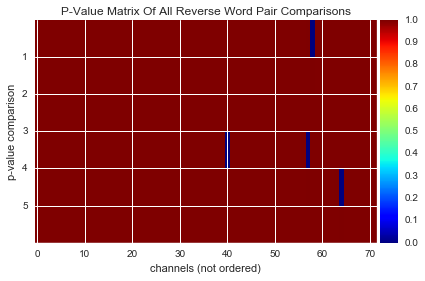

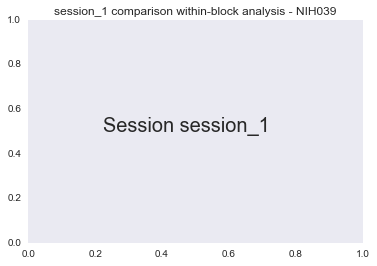

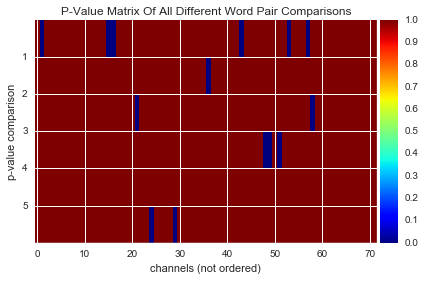

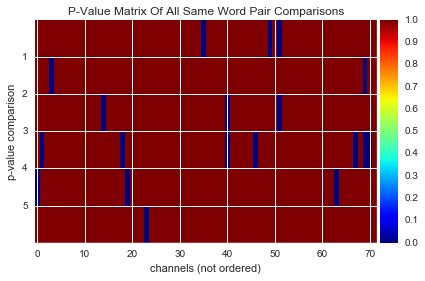

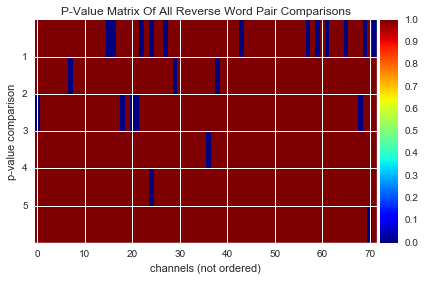

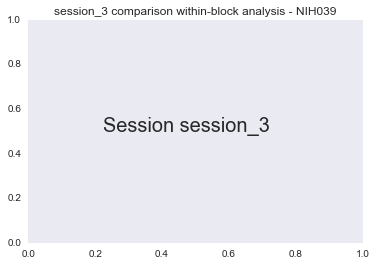

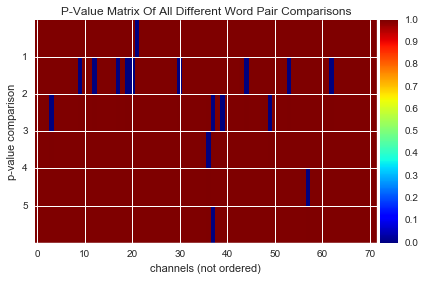

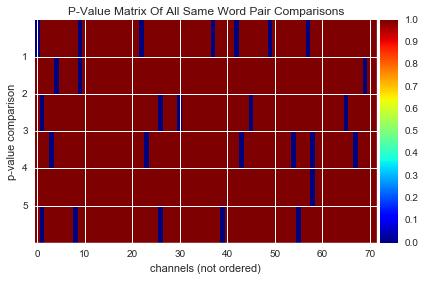

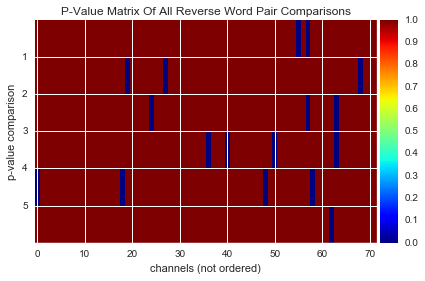

In [91]:
######## Get list of files (.mat) we want to work with ########
subj = 'NIH039'
filedir = '../../condensed_data_'+ subj +'/sessions/'
sessions = os.listdir(filedir)
# sessions = sessions[2:]

session_pval_dict = {}

debug_on = 1
# loop through each session
for session in sessions:
    print "Analyzing session ", session
    sessiondir = filedir + session
    
    session_pval_diff_mat = np.array(())
    session_pval_same_mat = np.array(())
    session_pval_reverse_mat = np.array(())
    
    # get all blocks for this session
    blocks = os.listdir(sessiondir)
    
    if len(blocks) != 6: # error check on the directories
        print blocks
        print("Error in the # of blocks. There should be 5.")
        break
    
    #### plot meta information about which session and blocks we're analyzing
    fig=plt.figure()
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    xmin, xmax = axes.get_xlim()
    plt.text((xmax-xmin)/4.5, (ymax-ymin)/2, r'Session %s'%(session), fontsize=20)
    plt.title(session + ' comparison within-block analysis - ' + subj)
    plt.grid(False)
        
    # loop through each block one at a time, analyze
    for i in range(0, 6):
        # var for block and directory
        block = blocks[i]
        block_dir = sessiondir + '/' + block
        
        # in each block, get list of word pairs from first and second block
        wordpairs = os.listdir(block_dir)
       
        # within-groups analysis only has: SAME, REVERSE, DIFFERENT
        diff_word_group = []
        reverse_word_group = []
        same_word_group = []
        
        ## 01: Create WordPair Groups
        same_word_group, reverse_word_group, diff_word_group = createWordGroups(wordpairs)
        
        # extract sessionblockdata dictionary
        block_data = extractSubjSessionBlockData(subj, session, block)
        
        if debug_on:
            print "Analyzing block ", blocks[i]
#             print "These are the wordpairs in this block: ", wordpairs
#             print "\n sameword: ", same_word_group
#             print "\n reverseword: ", reverse_word_group
#             print "\n diffword: ", diff_word_group
#             print block_data['data'].keys()
                
        channels = np.arange(1, num_chans+1, 1)
        block_pval_diff_vec = np.array(())
        block_pval_same_vec = np.array(())
        block_pval_reverse_vec = np.array(())
        ## 02: Create feature_dicts from each channel
        for jdx, chan in sorted(enumerate(channels)):
            same_p_val, reverse_p_val, diff_p_val = channelSignificance(chan, same_word_group, \
                                                                reverse_word_group, diff_word_group, block_data, low_freq_bands)

            block_pval_diff_vec = np.append(block_pval_diff_vec, diff_p_val)
            block_pval_same_vec = np.append(block_pval_same_vec, same_p_val)
            block_pval_reverse_vec = np.append(block_pval_reverse_vec, reverse_p_val)
#             break # only do 1 channel

        ## append block p-values to session level p-value matrix
        if session_pval_diff_mat.size == 0:
            session_pval_diff_mat = np.reshape(block_pval_diff_vec, (1, num_chans))
            session_pval_same_mat = np.reshape(block_pval_same_vec, (1, num_chans))
            session_pval_reverse_mat = np.reshape(block_pval_reverse_vec, (1, num_chans))
        else:
            session_pval_diff_mat = np.append(session_pval_diff_mat, np.reshape(block_pval_diff_vec, (1, num_chans)), axis=0)
            session_pval_same_mat = np.append(session_pval_same_mat, np.reshape(block_pval_same_vec, (1, num_chans)), axis=0)
            session_pval_reverse_mat = np.append(session_pval_reverse_mat, np.reshape(block_pval_reverse_vec, (1, num_chans)), axis=0)

        print session_pval_diff_mat.shape
        
#         break # loop through blocks

    print session_pval_diff_mat.shape
    ### plot p-value matrices
    buff = session_pval_diff_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0
    
    unique, counts = numpy.unique(buff, return_counts=True)
    count = dict(zip(unique, counts))
    print "different", count
    
    fig=plt.figure()
    ax=plt.gca()
    im = plt.imshow(buff, interpolation='none', cmap='jet', aspect='auto')
    plt.xlabel('channels (not ordered)')
    plt.ylabel('p-value comparison')
    plt.title('P-Value Matrix Of All Different Word Pair Comparisons')
    plt.yticks(np.arange(0.5,6,1), np.arange(1, 6, 1))
    vmin, vmax = plt.gci().get_clim()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()

    buff = session_pval_same_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0
    unique, counts = numpy.unique(buff, return_counts=True)
    count = dict(zip(unique, counts))
    print "same", count
    
    fig=plt.figure()
    ax=plt.gca()
    im = plt.imshow(buff, interpolation='none', cmap='jet', aspect='auto')
    plt.xlabel('channels (not ordered)')
    plt.ylabel('p-value comparison')
    plt.title('P-Value Matrix Of All Same Word Pair Comparisons')
    plt.yticks(np.arange(0.5,6,1), np.arange(1, 6, 1))
    vmin, vmax = plt.gci().get_clim()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()

    buff = session_pval_reverse_mat
    buff[buff>0.05] = 1
    buff[buff<0.05] = 0
    unique, counts = numpy.unique(buff, return_counts=True)
    count = dict(zip(unique, counts))
    print "reverse", count
    
    fig=plt.figure()
    ax=plt.gca()
    im = plt.imshow(buff, interpolation='none', cmap='jet', aspect='auto')
    plt.xlabel('channels (not ordered)')
    plt.ylabel('p-value comparison')
    plt.title('P-Value Matrix Of All Reverse Word Pair Comparisons')
    plt.yticks(np.arange(0.5,6,1), np.arange(1, 6, 1))
    vmin, vmax = plt.gci().get_clim()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
        
#     break # only do 1 session